In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.linalg import lu_factor,lu_solve
from scipy.stats import multivariate_normal as mn
def colors(n): 
    if n<4: return [[1,0,0],[0,0,1],[0,1,0]]
    ret = [] 
    r = int(random.random() * 256) 
    g = int(random.random() * 256) 
    b = int(random.random() * 256)
    for i in range(n):
        r = int(r/(n+1))/255
        g = int(g/(n+1))/255
        b = int(b/(n+1))/255
        ret.append((r,g,b))  
    return ret 

(105, 2) (190, 2)


/home/yui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


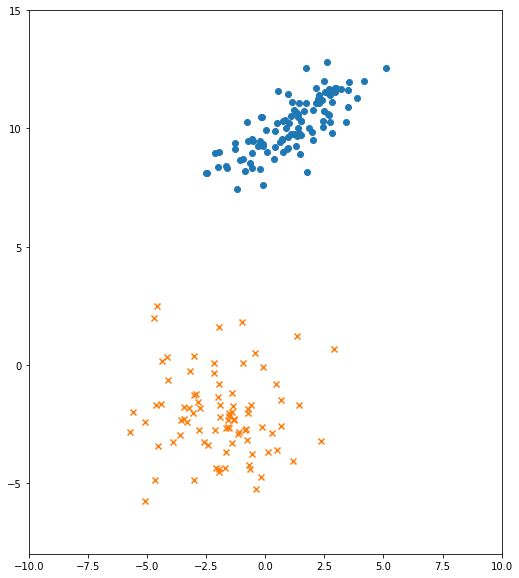

In [2]:
m1,m2 = np.array([10,1]),np.array([-2,-2])
v1,v2 = np.array([[1,0.5],[2,3]]),np.identity(2)*3
s1=np.random.multivariate_normal(m1,v1,105)
s2=np.random.multivariate_normal(m2,v2,85)
data = np.vstack((s1,s2))
np.random.shuffle(data)
print(s1.shape,data.shape)
plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
plt.scatter(s1[:,1],s1[:,0])
plt.scatter(s2[:,1],s2[:,0],marker='x')
plt.xlim([-10,10])
plt.ylim([-8,15])
ax.set_aspect('equal')

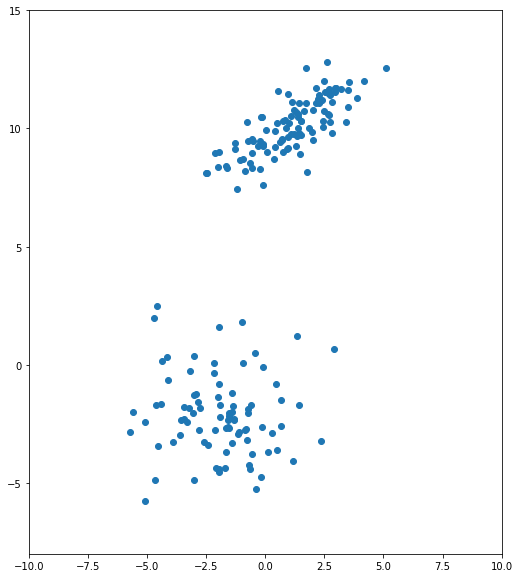

In [3]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
plt.scatter(data[:,1],data[:,0])
plt.xlim([-10,10])
plt.ylim([-8,15])
ax.set_aspect('equal')

### Clustering 2D samples
1. E-step
$$\begin{align*} q(s_n=k)&=r_{nk}=\frac{u_{nk}}{u_n} \\ 
u_{nk}&=\frac{\pi_k}{\sqrt{|2\pi\Sigma_k}|}e^{-\frac{1}{2} (x_n-\mu_k)^\top\Sigma_k^{-1}(x_n-\mu_k)} 
\\ u_n &= \sum^K_{k=1}u_{nk} \end{align*} 
$$
2. M-step
$$\begin{align*}
\mu_j &= \frac{\sum^N_{n=1}q(s_n=j)x_n}{\sum^N_{n=1}q(s_n=j)} \\
\sigma^2_j &= \frac{\sum^N_{n=1}q(s_n=j)(x_n-\mu_j)（x_n-\mu_j)^\top}{\sum^N_{n=1}q(s_n=j)} \\
\pi_j &= \frac{1}{N}\sum^N_{n=1}q(s_n=j)
\end{align*}
$$
3. Free Energy
$$\mathcal{F}(q(s),\theta)=\sum_n\sum_k q(s_n =k)\bigg(\log\pi_k -\frac{1}{2}\log|2\pi\Sigma_k|-\frac{1}{2}(x_n-\mu_k)^\top\Sigma^{-1}_k(x_n-\mu_k)\bigg)$$

### Likelihood
$$\begin{align*}
p(x_n|\theta)&=\sum^K_{j=1}\pi_j\mathcal{N}(x_n|\mu_j,\Sigma_j)\\
p(X|\pi,\mu,\Sigma)&=\prod^N_{n=1}\sum^K_{j=1}\pi_j\mathcal{N}(x_n|\mu_j,\Sigma_j)\\
\log p(X|\pi,\mu,\Sigma) &= \sum^N_{n=1}\log\sum^K_{j=1}\pi_j\mathcal{N}(x_n|\mu_j,\Sigma_j)
\end{align*}$$

### Criterions
1. **Akaike Information Criterion (AIC)**
$$\text{AIC} = 2k-2\log\hat{L}$$
where $k$ number of estimated parameters in the model, $\hat{L}$ the maximum value of likelihood function of the model.
2. **Bayesian Information Criterion (BIC)**
$$\text{BIC} = k\log n-2\log\hat{L}$$
where $k$ number of parameters estimated by the model, $\hat{L}$ the maximized value of the likelihood function, $n$ number of data points

In [4]:
def e_step(data,m,v,p,k):
    L = data.shape[0]
    r = np.zeros((L,k))
    for d in range(k):
        r[:,d] = mn(m[d],v[d]).pdf(data)*p[d]
    r/=np.sum(r,axis=1,keepdims=1)
    return r

In [5]:
def m_step(data,r,k):
    L = r.shape[0]
    q_k = np.sum(r,axis=0)
    p = q_k/L
    m = np.dot(r.T,data)/q_k.reshape(-1,1)
    v = np.zeros((k,2,2))
    for d in range(k):
        dif = (data-m[d]).T
        v[d] = np.dot(r[:,d]*dif,dif.T)/q_k[d]
    return m,v,p

In [6]:
def plot_ell(ax,mu,cov):
    eig_vals, eig_vecs = np.linalg.eigh(cov)
    unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
    angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
    # Ellipse needs degrees
    angle = 180 * angle / np.pi
    # eigenvector normalization
    eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
    ell = Ellipse((mu[0],mu[1]),
        eig_vals[0], eig_vals[1], 180 + angle, edgecolor="black"
    )
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.4)
    ell.set_facecolor("#56B4E9")
    ax.add_artist(ell)

In [7]:
def gmm_2d(data,k=2,iters=10,seed=None,debug=True):
    if seed!=None:
        random.seed(seed)
    L,d = data.shape[:2]
    mi,ma = np.min(data,axis=0),np.max(data,axis=0)
    m = np.random.uniform(mi,ma,(k,d))
    v = np.zeros((k,2,2))
    for i in range(k): 
        v[i,:,:] = np.identity(2)*0.5
    p = np.random.uniform(0,1,k)
    p /= sum(p)
    
    r = e_step(data,m,v,p,k)
    s = np.argmax(r,axis=1)
    if debug:
        plt.figure(figsize=((iters//3+1)*5,(iters//3+1)*10))
    cs = colors(len(p))
    res = []
    for it in range(iters):
        if debug:
            ax = plt.subplot(iters//3+1,3,it+1)
            ax.set_xlim([-8,15])
            ax.set_ylim([-10,10])
            ax.set_aspect('equal')
            for d in range(len(p)):
                ax.scatter(data[s==d,0],data[s==d,1],color=cs[d])
                plot_ell(ax,m[d],v[d])
        r = e_step(data,m,v,p,k)
        res.append(np.sum(r*np.log(r)))
        m,v,p = m_step(data,r,k)
        s = np.argmax(r,axis=1)

    if debug:
        it+=1
        ax = plt.subplot(iters//3+1,3,it+1)
        plt.plot(range(iters),res)
    npa = d*d*k+d*k+k
    like = np.sum(np.log(np.sum(r,axis=1)),axis=0)
    aic = 2*npa-2*like
    bic = npa*np.log(L)-2*like
    return res,aic,bic

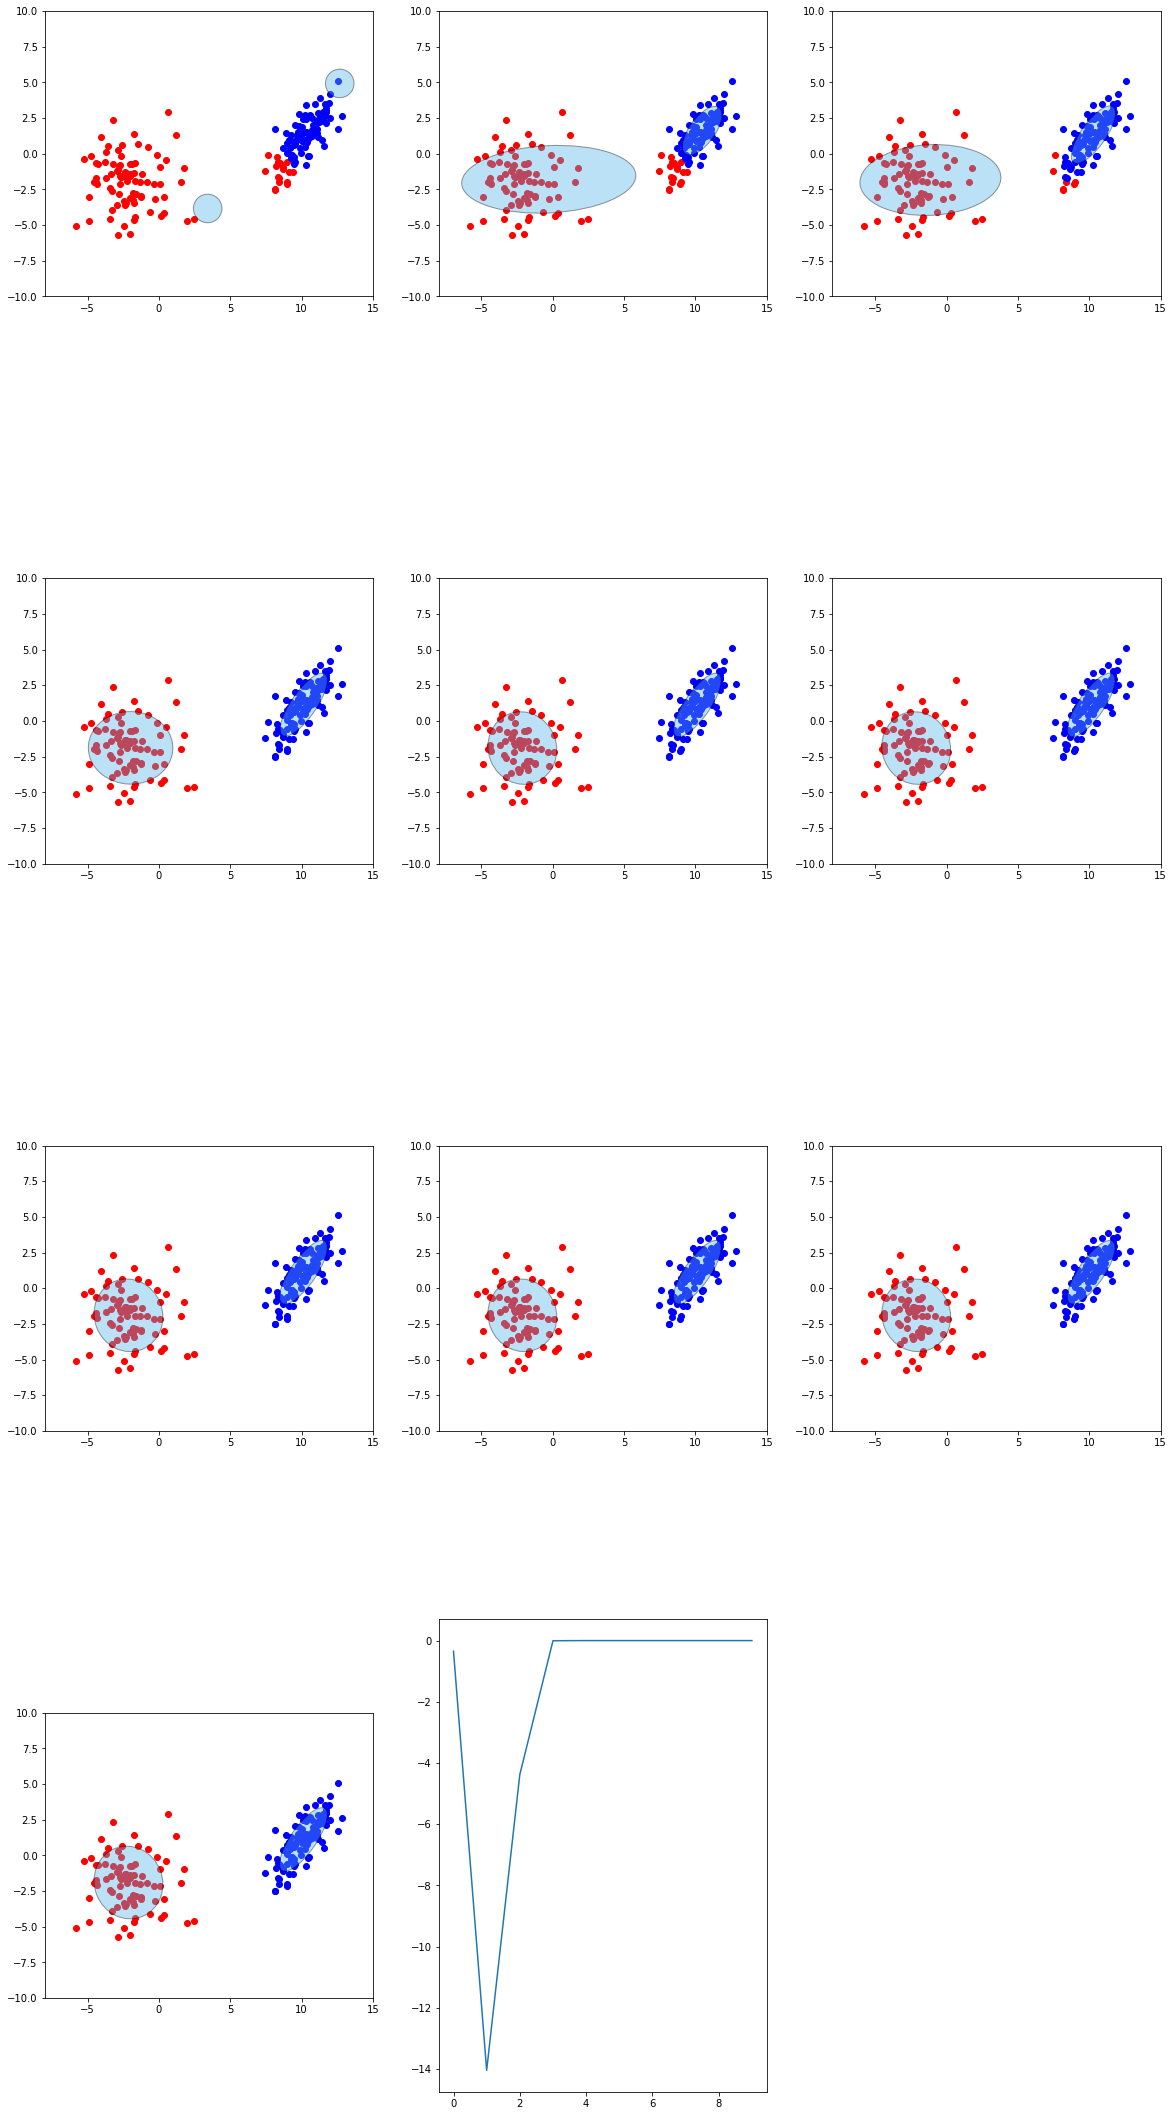

In [8]:
res,aic,bic = gmm_2d(data,k=2)

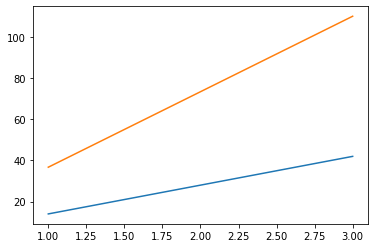

In [10]:
aics,bics = [],[]
for i in range(1,4):
    _,a,b = gmm_2d(data,k=i,debug=False)
    aics.append(a)
    bics.append(b)
plt.plot(range(1,4),aics)
plt.plot(range(1,4),bics)

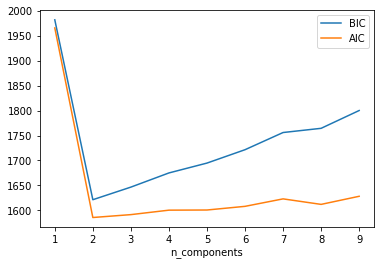

In [11]:
from sklearn.mixture import GaussianMixture
n_components = np.arange(1, 10)
clfs = [GaussianMixture(n, max_iter = 1000).fit(data) for n in n_components]
bics = [clf.bic(data) for clf in clfs]
aics = [clf.aic(data) for clf in clfs]

plt.plot(n_components, bics, label = 'BIC')
plt.plot(n_components, aics, label = 'AIC')
plt.xlabel('n_components')
plt.legend()